# Programs to implements a psycho-acoustic model<br/> Using a matrix for the spreading function (faster)
### Gerald Schuller, Nov. 2016

### This program lists various functions required for implement psychoacoustics model and the applying it to sample frequency spectrum as you will see it below:

* **Importing relevant modules**

In [1]:
import numpy as np

* **Spreading function - creating a prototype spreading function across all the bands**

In [2]:
def spreadingfunctionmat(maxfreq,nfilts,alpha):
    #usage: spreadingfuncmatrix=spreadingfunctionmat(maxfreq,nfilts,alpha)
    #computes a matrix with shifted spreading functions in each column, in the Bark scale.
    #including the alpha exponent for non-linear superposition
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64

    fadB = 14.5 + 12 + 5 # Simultaneous masking for tones at Bark band 12
    fbdb = 7.5     # Upper slope of spreading function
    fbbdb = 26.0   # Lower slope of spreading function      

    maxbark = hz2bark(maxfreq)
    spreadingfunctionBarkdB = np.zeros(2 * nfilts)

    #upper slope, fbdB attenuation per Bark, over maxbark Bark (full frequency range), with fadB dB simultaneous masking:
    spreadingfunctionBarkdB[0 : nfilts] = np.linspace(-maxbark * fbdb, -2.5, nfilts) - fadB
    
    #lower slope fbbdb attenuation per Bark, over maxbark Bark (full frequency range):
    spreadingfunctionBarkdB[nfilts : 2 * nfilts] = np.linspace(0, -maxbark * fbbdb, nfilts) - fadB
    
    #Convert from dB to "voltage" and include alpha exponent
    spreadingfunctionBarkVoltage = 10.0 ** (spreadingfunctionBarkdB / 20.0 * alpha)

    #Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix = np.zeros((nfilts, nfilts))
    for k in range(nfilts):
        spreadingfuncmatrix[:,k] = spreadingfunctionBarkVoltage[(nfilts-k):(2 * nfilts - k)]
    return spreadingfuncmatrix

* **Function for computing Masking Threshold for the given bark. Computes the masking threshold on the Bark scale with non-linear superposition**

In [3]:
def maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha): 
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, 
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6)
    #return: masking threshold as "voltage" on Bark scale 

    #mXbark: is the magnitude-spectrum mapped to the Bark scale, 
    #mTbark: is the resulting Masking Threshold in the Bark scale 


    mTbark=np.dot(mXbark**alpha, spreadingfuncmatrix)

    #apply the inverse exponent to the result:
    mTbark=mTbark**(1.0/alpha)
    #print "mX[frameindx, 0] ", mX[frameindx, 0]

    return mTbark

* **Function to convert frequencies from Hz to Bark absed on Schröder's Approximation**

In [4]:
def hz2bark(f):
    """ Method to compute Bark from Hz. Based on :
    https://github.com/stephencwelch/Perceptual-Coding-In-Python
    Args     :
        f    : (ndarray)    Array containing frequencies in Hz.
    Returns  :
        Brk  : (ndarray)    Array containing Bark scaled values.
    """
    Brk = 6. * np.arcsinh(f/600.)                                                 
    return Brk

* **Similarly for the inverse i.e., from Bark to Hz.**

In [5]:
def bark2hz(Brk):
    """ Method to compute Hz from Bark scale. Based on :
    https://github.com/stephencwelch/Perceptual-Coding-In-Python
    Args     :
        Brk  : (ndarray)    Array containing Bark scaled values.
    Returns  :
        Fhz  : (ndarray)    Array containing frequencies in Hz.
    """
    Fhz = 600. * np.sinh(Brk/6.)

    return Fhz

* **Function for constructing mapping matrix W which has 1's for each Bark subband, and 0's else**

In [6]:
def mapping2barkmat(fs, nfilts,nfft):
    #usage: W=mapping2barkmat(fs, nfilts,nfft)  
    #arguments: fs: sampling frequency
    #nfilts: number of subbands in Bark domain
    #nfft: number of subbands in fft

    nfreqs=nfft/2; step_barks = 24.0/(nfilts-1)
    binbarks = hz2bark(np.linspace(0,(nfft/2),(nfft/2)+1)*fs/nfft)
    W = np.zeros((nfilts, nfft))
    for i in xrange(nfilts):
        W[i,0:(nfft/2)+1] = (np.round(binbarks/step_barks)== i)
    return W

* **Function that maps (warps) magnitude spectrum vector mX from DFT to the Bark scale**

In [7]:
def mapping2bark(mX,W,nfft):
    #arguments: mX: magnitude spectrum from fft
    #W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    #returns: mXbark, magnitude mapped to the Bark scale

    #Frequency of each FFT bin in Bark, in 1025 frequency bands (from call)
    nfreqs=nfft/2

    #Frequencies of each FFT band, up to Nyquits frequency, converted to Bark:
    #Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (np.dot( np.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
    return mXbark

* **Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale**

In [8]:
def mappingfrombarkmat(W,nfft):
    #usuage: W_inv=mappingfrombarkmat(Wnfft)
    #argument: W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft

    nfreqs = nfft / 2
    W_inv = np.dot(np.diag((1.0 / np.sum(W, 1)) ** 0.5), W[:,0:nfreqs + 1]).T
    return W_inv

* **Function for mapping the threshold in Bark to Linear domain**

In [9]:
def mappingfrombark(mTbark,W_inv,nfft):
    #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
    #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    #arguments:
    #mTbark: masking threshold in the Bark domain
    #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #nfft: : number of subbands in fft
    #returns: mT, masking threshold in the linear scale
    nfreqs = nfft/2
    mT = np.dot(mTbark, W_inv[:, :nfreqs].T)
    return mT

* **Function to compute masking threshold in voltage in each subband**

In [10]:
def maskingThreshold(mX, W, W_inv,fs, spreadingfuncmatrix,alpha):
    #usage: mT=maskingThreshold(mX, W, W_inv,fs)
    #Input: mX: magnitude spectrum of a DFT of size 2048
    #W: mapping matrix from function mapping2barkmat
    #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #fs: sampling frequency of the audio signal
    #Returns: masking threshold (as voltage) for its first 1025 subbands

    #Map magnitude spectrum to 1/3 Bark bands:
    mXbark=mapping2bark(mX,W,nfft)
    
    #Compute the masking threshold in the Bark domain:
    mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    
    #Map back from the Bark domain, 
    #Result is the masking threshold in the linear domain:
    mT = mappingfrombark(mTbark, W_inv, nfft)

    #Threshold in quiet:
    f = np.linspace(0, fs/2, 1025)

    #LTQ=np.min((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.),80*np.ones(len(f))),0)
    LTQ = np.clip((3.64*(f/1000.) ** - 0.8 - 6.5 * np.exp(-0.6 * (f / 1000. - 3.3) ** 2.) + 1e-3 *((f / 1000.) ** 4.)), -20, 80)
    mT=np.max((mT, 10.0**((LTQ-60)/20)),0)
    return mT

* **Testing the model**
  * Firstly defining the relevant parameters

In [11]:
if __name__ == '__main__':
    #testing:
    import matplotlib.pyplot as plt

    fs = 32000  # sampling frequency of audio signal
    maxfreq = fs/2
    alpha = 0.6  #Exponent for non-linear superposition of spreading functions
    nfilts = 64  #number of subbands in the bark domain
    nfft = 2048  #number of fft subbands

* **Computing the prototype 'W' and 'W_inv' matrix where bands are mapped to bark(W) and mapped from bark(W_inv) **

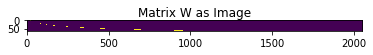

In [12]:
    W=mapping2barkmat(fs,nfilts,nfft)
    plt.imshow(W)
    plt.title('Matrix W as Image')
    plt.show()

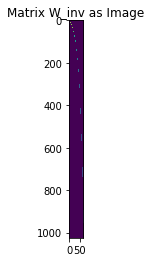

In [13]:
    W_inv=mappingfrombarkmat(W,nfft)
    plt.imshow(W_inv)
    plt.title('Matrix W_inv as Image')
    plt.show()

> This is the representation where you see mapping of subbands to bark and back. As it is seen in the plot the dotted chunked lines have increased sizes in the higher subbands.

* **Computing the spreading function prototype for each of the barkbands**

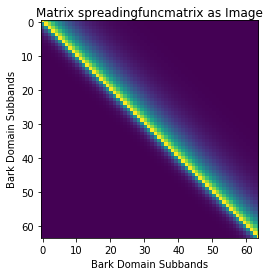

In [14]:
  spreadingfuncmatrix=spreadingfunctionmat(maxfreq,nfilts,alpha)
  plt.imshow(spreadingfuncmatrix)
  plt.title('Matrix spreadingfuncmatrix as Image')
  plt.xlabel('Bark Domain Subbands')
  plt.ylabel('Bark Domain Subbands')
  plt.show()

* **Consider an example magnitude spectrum 'A' and apply the model**

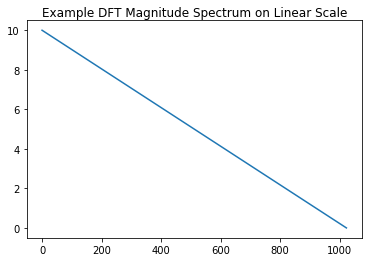

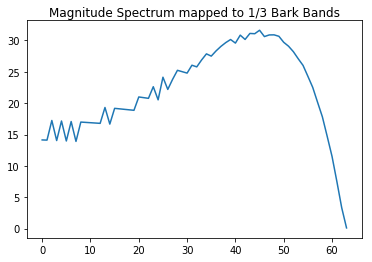

mXbark [ 14.13522522  14.10757687  17.23585815  14.03845598  17.15120272
  13.96933509  17.06654728  13.9002142   16.98189184  16.93109858
  16.88030532  16.82951206  16.7787188   19.30597523  16.66020119
  19.16912292  19.0909216   19.01272029  18.93451897  18.85631765
  20.98365188  20.87436227  20.76507265  22.61531617  20.52463551
  24.1299281   22.18432163  23.79371415  25.22920712  25.00802095
  24.78683479  26.0411658   25.77723731  26.87796117  27.84946237
  27.49283849  28.32595968  29.04208094  29.64468055  30.1362674
  29.56838981  30.83324026  30.14808557  31.10543298  31.06116557
  31.61464874  30.60600129  30.86582977  30.88048947  30.65011396
  29.69273821  29.06747998  28.19442001  27.07106515  26.0098089
  24.27625899  22.5131867   20.14917436  17.81710967  14.69579205
  11.50897607   7.51143506   3.33868961   0.11566138]
mXbark.shape = (64,)


In [15]:
    mX=np.linspace(10,0,1024)

    plt.plot(mX)
    plt.title('Example DFT Magnitude Spectrum on Linear Scale')
    plt.show()
    
    mXbark=mapping2bark(mX,W, nfft)
    plt.plot(mXbark)
    plt.title('Magnitude Spectrum mapped to 1/3 Bark Bands')
    plt.show()
    
    print "mXbark", mXbark
    print "mXbark.shape =",mXbark.shape

* **Generating masking threshold for each bark**

In [16]:
    mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)

* **Plotting the masking threshold for each bark/band in both the domains(Bark domain and Linear domain)**

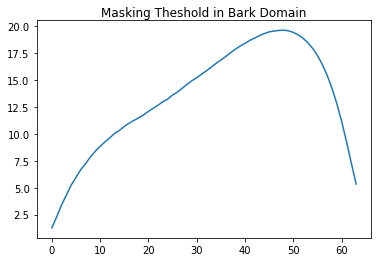

In [17]:
  plt.plot(mTbark)
  plt.title('Masking Theshold in Bark Domain')
  plt.show()

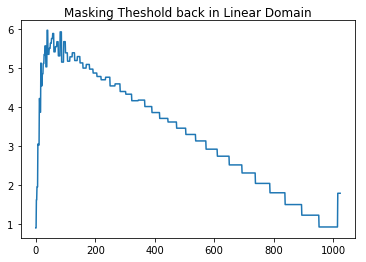

In [18]:
  mT=mappingfrombark(mTbark,W_inv,nfft)
  plt.plot(mT)
  plt.title('Masking Theshold back in Linear Domain')
  plt.show()

* **Plotting the complete masking threshold based on the spreading function**

In [19]:
spreadingfuncmatrix

array([[  1.13501082e-01,   9.54992586e-02,   7.86993081e-02, ...,
          8.67470746e-07,   7.14867827e-07,   5.89110368e-07],
       [  5.74873361e-02,   1.13501082e-01,   9.54992586e-02, ...,
          1.05264983e-06,   8.67470746e-07,   7.14867827e-07],
       [  2.91168486e-02,   5.74873361e-02,   1.13501082e-01, ...,
          1.27735911e-06,   1.05264983e-06,   8.67470746e-07],
       ..., 
       [  1.08119304e-19,   2.13467153e-19,   4.21462436e-19, ...,
          1.13501082e-01,   9.54992586e-02,   7.86993081e-02],
       [  5.47615114e-20,   1.08119304e-19,   2.13467153e-19, ...,
          5.74873361e-02,   1.13501082e-01,   9.54992586e-02],
       [  2.77362415e-20,   5.47615114e-20,   1.08119304e-19, ...,
          2.91168486e-02,   5.74873361e-02,   1.13501082e-01]])

In [20]:
    mT = maskingThreshold(mX, W, W_inv,fs, spreadingfuncmatrix,alpha)
    mT

c:\python27\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: divide by zero encountered in power


array([ 10.        ,  10.        ,   1.61447404, ...,   1.86685646,
         1.92238004,   1.97972572])

c:\python27\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: divide by zero encountered in power


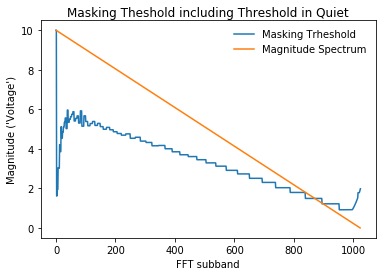

In [21]:
    mT = maskingThreshold(mX, W, W_inv,fs, spreadingfuncmatrix,alpha)
    
    plt.plot(mT)
    plt.title('Masking Theshold including Threshold in Quiet')
    plt.plot(mX)
    plt.legend(('Masking Trheshold', 'Magnitude Spectrum'))
    plt.xlabel('FFT subband')
    plt.ylabel("Magnitude ('Voltage')")
    plt.show()

* **A test magnitude spectrum, an idealized tone in one subband:**

c:\python27\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: divide by zero encountered in power


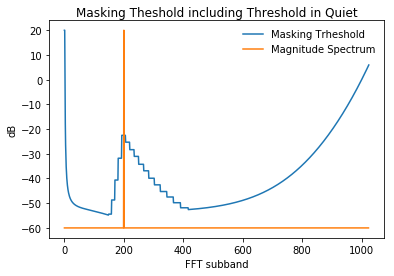

In [22]:
    mX=np.zeros(1024)
    mX[200]=10;
    mT=maskingThreshold(mX, W, W_inv,fs, spreadingfuncmatrix,alpha)
    plt.plot(20*np.log10(mT+1e-3))
    plt.title('Masking Theshold including Threshold in Quiet')
    plt.plot(20*np.log10(mX+1e-3))
    plt.legend(('Masking Trheshold', 'Magnitude Spectrum'))
    plt.xlabel('FFT subband')
    plt.ylabel("dB")
    plt.show()